In [2]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset, random_split, Dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Utilize GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Convert tensor to matplotlib-compatible image
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))  # CHW -> HWC
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

In [5]:
val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
#Load full dataset
data_dir = "dataset"
dataset = ImageFolder(data_dir, transform=val_transforms)

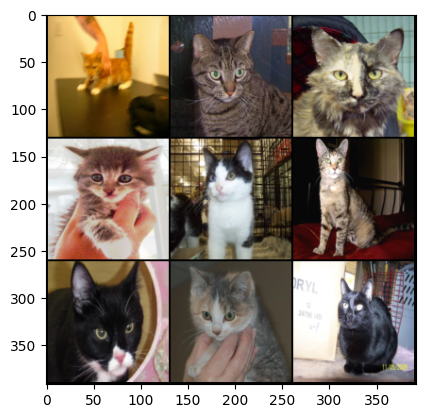

In [7]:
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=2)
images, labels = next(iter(loader))
grid = torchvision.utils.make_grid(images[:9], nrow=3, padding=2, normalize=True)
plt.imshow(grid.permute(1,2,0))

In [8]:
class TinyVGG(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(TinyVGG, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 128x128 -> 64x64
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 64x64 -> 32x32
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 32x32 -> 16x16
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        return self.classifier(x)

In [9]:
model = TinyVGG().to(device)
model.load_state_dict(torch.load('weights_tinyvgg.pth')["model_state_dict"])
model.eval()

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536

In [10]:
classification = lambda e: "cat" if e==0 else "dog"

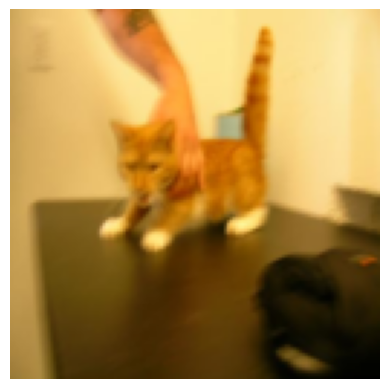

The model classified the image as a(n) cat with a confidence of 0.7837264537811279 and it's a(n) cat


In [11]:
image, label = dataset[0]
imshow(image)
image = image.unsqueeze(0).to(device)
logits = model(image)
confidence, prediction = torch.max(F.softmax(logits, dim=1), dim=1)
print("The model classified the image as a(n)", classification(prediction), "with a confidence of", confidence.item(), "and it's a(n)", classification(label))

In [12]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total learnable parameters: {total_params}")

Total learnable parameters: 34701378


Visualize activation maps of all blocks

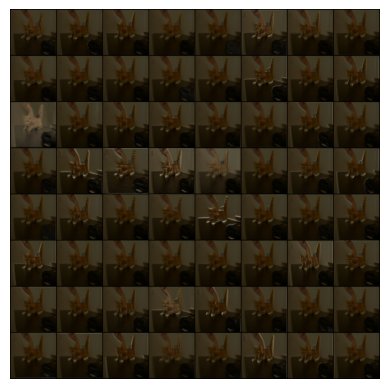

In [13]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
model.block1[3].register_forward_hook(get_activation('layer1'))
model.block2[3].register_forward_hook(get_activation('layer2'))
model.block3[3].register_forward_hook(get_activation('layer3'))

data, _ = dataset[0]
data.unsqueeze_(0)
output = model(image)
act = activation['layer1'].squeeze()
image_s = image.repeat(act.shape[0],1,1,1)
act = act.unsqueeze(1)

grid_img = torchvision.utils.make_grid(image_s, nrow=8, padding=2, normalize=True)
grid = torchvision.utils.make_grid(act, nrow=8, padding=2, normalize=True)
combined = (grid_img/2 + grid)/2
img = plt.imshow(combined.cpu().permute(1,2,0))
plt.axis('off')
plt.imsave("layer1_act_maps_tinyvgg.png", grid.cpu()[0])
plt.imsave("layer1_act_maps_tinyvgg_ov.png", combined.cpu().permute(1,2,0))

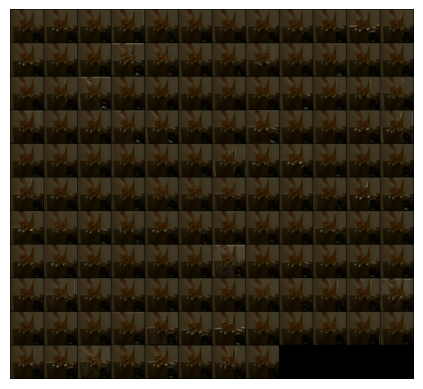

In [14]:
act2 = activation['layer2'].squeeze()
act2 = act2.unsqueeze(1)

image_s = image.repeat(act2.shape[0],1,1,1)
act2 = F.interpolate(act2, (image_s.shape[2], image_s.shape[3]))

grid = torchvision.utils.make_grid(act2, nrow=12, padding=2, normalize=True)
grid_img = torchvision.utils.make_grid(image_s, nrow=12, padding=2, normalize=True)
combined = (grid + grid_img/2)/2

img = plt.imshow(combined.cpu().permute(1,2,0))
plt.axis('off')
plt.imsave("layer2_act_maps_tinyvgg.png", grid.cpu()[0])
plt.imsave("layer2_act_maps_tinyvgg_ov.png", combined.cpu().permute(1,2,0))

torch.Size([256, 1, 32, 32])


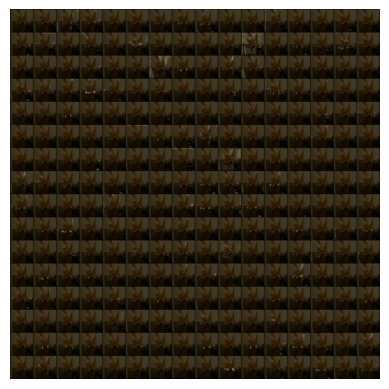

In [15]:
act3 = activation['layer3'].squeeze()
act3 = act3.unsqueeze(1)
print(act3.shape)
image_s = image.repeat(act3.shape[0],1,1,1)
act3 = F.interpolate(act3, (image_s.shape[2], image_s.shape[3]))
grid = torchvision.utils.make_grid(act3, nrow=16, padding=2, normalize=True)
grid_img = torchvision.utils.make_grid(image_s, nrow=16, padding=2, normalize=True)
combined = (grid + grid_img/2)/2
img = plt.imshow(combined.cpu().permute(1,2,0))
plt.axis('off')
plt.imsave("layer3_act_maps_tinyvgg.png", grid.cpu()[0])
plt.imsave("layer3_act_maps_tinyvgg_ov.png", combined.cpu().permute(1,2,0))

In [16]:
with torch.no_grad():
    correct = 0
    for i, (image, label) in enumerate(loader):
        image = image.to(device)
        label = label.to(device)
        # if random.random() > 0.5:
        #     image = transforms.functional.invert(image)
        prediction = torch.max(model(image),1)[1]
        correct += (prediction == label).sum()



/home/stelios/Documents/projects/torch_venv/lib64/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [17]:
acc_percent = correct.item()/len(dataset)*100
print("Accuracy on entire dataset:", acc_percent)

Accuracy on entire dataset: 94.96759740779262


Demonstrate a few images that the model misclassifies

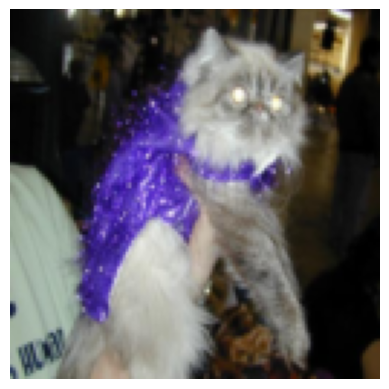

The model classified the image as a(n) dog with a confidence of 0.9848139882087708 but it's a(n) cat


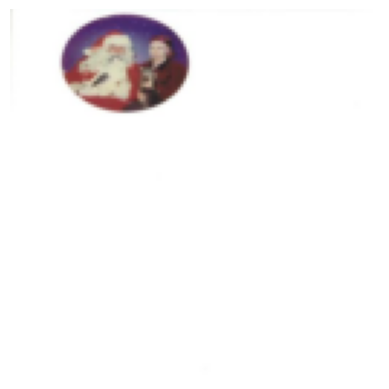

The model classified the image as a(n) dog with a confidence of 0.8341997265815735 but it's a(n) cat


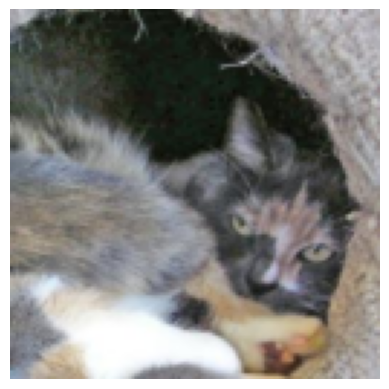

The model classified the image as a(n) dog with a confidence of 0.7070416808128357 but it's a(n) cat


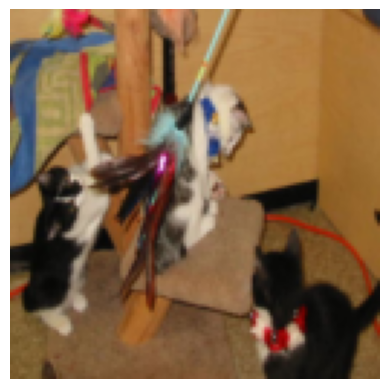

The model classified the image as a(n) dog with a confidence of 0.9944518208503723 but it's a(n) cat


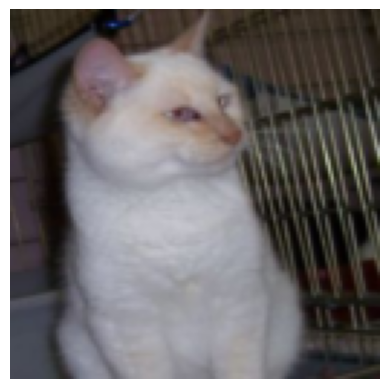

The model classified the image as a(n) dog with a confidence of 0.6323682069778442 but it's a(n) cat


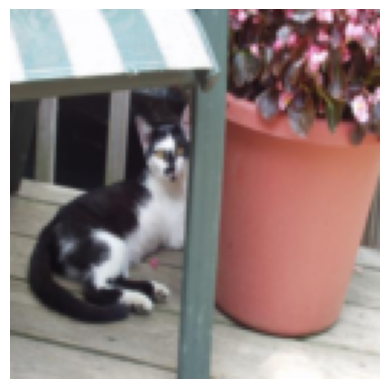

The model classified the image as a(n) dog with a confidence of 0.5124961137771606 but it's a(n) cat


In [18]:
c = 0
for image, label in dataset:
    logits = model(image.to(device).unsqueeze(0))
    confidence, prediction = torch.max(F.softmax(logits, dim=1), dim=1)
    if prediction!=label:
        c+=1
        imshow(image)
        print("The model classified the image as a(n)", classification(prediction), "with a confidence of", confidence.item(), "but it's a(n)", classification(label))
        if c>5:
            break